In [1]:
%load_ext autoreload
%load_ext line_profiler
%autoreload 2

In [120]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy import special, integrate, optimize

from ricciardi_nb import Ricciardi, RegularGridInterpolator, ricciardi, ricciardi_fast, ricciardi_approx, ricciardi_np, ierfcx, ierfcx_fast, dawson, dawson_approx, erfi, ierfcx_exact, ierfcx_approx, ierfcx_chebyshev, ierfcx_chebyshev_fast, ierfcx_chebyshev_np, ierfcx_asymptotic_fast
import ricciardi as ric2
from ricciardi import dawsn

In [3]:
torch.autograd.set_detect_anomaly(True)

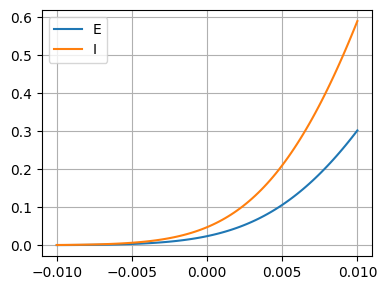

In [121]:
x = torch.linspace(-0.01, 0.01, 101)
plt.plot(x, 0.025 * ricciardi_fast(x, tau=0.02), label='E')
plt.plot(x, 0.025 * ricciardi_fast(x, tau=0.01), label='I')
plt.grid(which='both')
plt.legend()
plt.show()

In [42]:
def poly1d(coef, x):
    power = torch.arange(len(coef), device=x.device)
    return (coef * x[:, None]**power).sum(dim=-1)

In [17]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available() and torch.backends.mps.is_built():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(device)
device = 'cpu'

c = torch.tensor([1.0, -0.5, 0.25, -0.125, 0.25, 0.2, -0.1, 0.05], device=device)
x = torch.linspace(-5.0, 5.0, 100001, device=device)
%timeit poly1d(c, x)
%timeit c[0] + (c[1] + (c[2] + (c[3] + (c[4] + (c[5] + (c[6] + c[7] * x) * x) * x) * x) * x) * x) * x

mps
1.55 ms ± 4.37 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
310 µs ± 8.28 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [3]:
points, values = torch.tensor([-1.0, 2.0]), torch.tensor([-1.0, 2.0])
interpolator = RegularGridInterpolator((points,), values)
x = torch.linspace(0, 1, 10)[None, ...]
y = interpolator(x)
print(x, y)
x.requires_grad = True
x = x.double()
interpolator.double()
print(interpolator(x + 1.0e-5))
print(interpolator(x - 1.0e-5))
print((interpolator(x + 1.0e-5) - interpolator(x - 1.0e-5)) / 2.0e-5)
torch.autograd.gradcheck(interpolator, x)

tensor([[0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
         1.0000]]) tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], grad_fn=<DivBackward0>)
tensor([1.0000e-05, 1.1112e-01, 2.2223e-01, 3.3334e-01, 4.4445e-01, 5.5557e-01,
        6.6668e-01, 7.7779e-01, 8.8890e-01, 1.0000e+00], dtype=torch.float64,
       grad_fn=<DivBackward0>)
tensor([-1.0000e-05,  1.1110e-01,  2.2221e-01,  3.3332e-01,  4.4443e-01,
         5.5555e-01,  6.6666e-01,  7.7777e-01,  8.8888e-01,  9.9999e-01],
       dtype=torch.float64, grad_fn=<DivBackward0>)
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000], dtype=torch.float64, grad_fn=<DivBackward0>)


True

In [198]:
def neg_erfcx_integral_approx(a, b, order=10):
    """
    Integral of erfcx(-x) = w(-ix) where w(z) is the Faddeeva function,
    with the series expansion w(z) = \sum_{n=0}^\infty \frac{(iz)^n}{\Gamma(n/2 + 1)}
    Thus erfcx(-x) = \sum_{n=0}^\infty \frac{x^n}{\Gamma(n/2 + 1)}
    so \int_a^b erfcx(x) dx = \sum_{n=0}^\infty \frac{(b^{n+1} - a^{n+1})}{(n+1)\Gamma(n/2 + 1)}
    """
    n = torch.arange(order, device=x.device)
    a, b = a[..., None], b[..., None]
    return ((b**(n + 1) - a**(n + 1)) / ((n + 1) * (n / 2 + 1).lgamma().exp())).sum(dim=-1)

@np.vectorize
def neg_erfcx_integral_exact(a, b):
    return integrate.quad(special.erfcx, -b, -a)[0]

@np.vectorize
def erfcx_integral_exact(a, b):
    return integrate.quad(special.erfcx, a, b)[0]

def inv_map(t, k=4.0):
    return k * (1 + t) / (1 - t)

def chebyshev(n, x):
    return torch.cos(n * torch.acos(x))

def monic(n, x):
    return x ** n

def erfcx_integral_approx(x, order=10):
    """
    Integral of erfcx(x) = w(ix) where w(z) is the Faddeeva function,
    with the series expansion w(z) = \sum_{n=0}^\infty \frac{(iz)^n}{\Gamma(n/2 + 1)}
    Thus erfcx(x) = \sum_{n=0}^\infty \frac{(-x)^n}{\Gamma(n/2 + 1)}
    so \int_0^x erfcx(y) dy = \sum_{n=0}^\infty (-1)^n \frac{x^{n+1}}{(n+1)\Gamma(n/2 + 1)}
    = x \sum_{n=0}^\infty \frac{(-x)^n}{(n+1)\Gamma(n/2 + 1)}
    """
    n = torch.arange(order, device=x.device)
    return x * ((-x[..., None])**n / ((n + 1) * (n / 2 + 1).lgamma().exp())).sum(dim=-1)

def factorial2(n):
    out = 2 ** (n / 2) * (n / 2 + 1).lgamma().exp()
    return torch.where(n % 2 == 1, out * (2 / np.pi)**0.5, out)

def erfcx_integral_asymptotic(x, min_x=1.0, order=10):
    """
    Integral of erfcx(x) = e^(x^2)erfc(x), with the asymptotic expansion
    erfcx(x) ~ \frac{1}{\sqrt{\pi}}(\frac{1}{x} + \sum_{n=1}^\infty \frac{(-1)^n(2n - 1)!!}{x(2x^2)^n})
    so \int erfcx(x) dx = \frac{1}{\sqrt{\pi}}(\log(x) + \sum_{n=1}^\infty \frac{(-1)^n(2n - 1)!!}{2n(2x^2)^n})
    """
    assert min_x > 0.0
    n = torch.arange(1, order, device=x.device)
    
    def f(x):
        return 1 / np.pi**0.5 * (torch.log(x) - ((-1)**n * factorial2(2 * n - 1) / (2 * n * (2 * x[..., None]**2)**n)).sum(dim=-1))
        
    out = f(x) - f(torch.tensor(min_x)) + erfcx_integral_exact(0, min_x)
    return out

In [8]:
x = torch.linspace(-5.0, 5.0, 101).double()
# x.require_grad = True
%timeit erfi(x)
%timeit ric2.erfi(x)
# %timeit torch.autograd.functional.jacobian(erfi, x)
# %timeit torch.autograd.functional.jacobian(ric2.erfi, x)

92 µs ± 220 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
95.5 µs ± 180 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [21]:
x = torch.linspace(-5.0, 5.0, 101).double()
x.require_grad = True
%timeit ierfcx_fast(x)
%timeit ric2.ierfcx(x)
%timeit torch.autograd.functional.jacobian(ierfcx_fast, x)
%timeit torch.autograd.functional.jacobian(ric2.ierfcx, x)

153 µs ± 976 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
139 µs ± 396 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
29.9 ms ± 437 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
2.09 ms ± 40.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


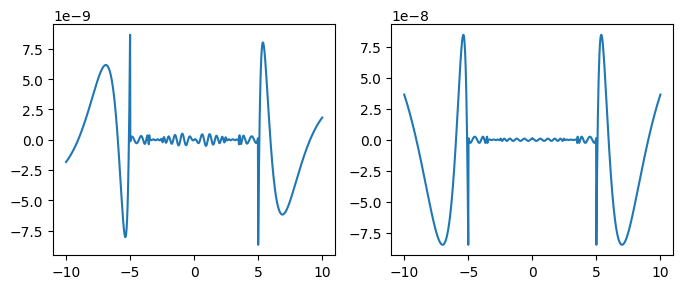

In [5]:
x = torch.linspace(-10, 10, 1001).double()
y = dawsn(x)
# y = dawsn2(x)
expected = special.dawsn(x)
fig, axes = plt.subplots(1, 2, figsize=(8, 3))
# plt.plot(x, expected)
# plt.plot(x, y)
axes[0].plot(x, y - expected)
axes[1].plot(x, (y - expected) / expected)
plt.show()

# x = torch.linspace(9.0, 10.0, 101)
# plt.plot(x, special.erfi(x))
# plt.plot(x, erfi(x))
# plt.plot(x, 2 / np.sqrt(np.pi) * torch.exp(x**2) * dawson_approx(x))
# plt.plot(x, 2 / np.sqrt(np.pi) * torch.exp(x**2) * x / (1 + 2 * x**2))
# plt.yscale('log')
plt.show()

[0.9094820912164773, -0.09203126277995884, 0.0006018640390670595, 0.0013999406674571643, -0.0005741164823348891, 0.000115823767473285, -2.1732892860991547e-05, 3.344686759961431e-06, -6.467928466887447e-07]
[ 9.09482092e-01 -9.20312745e-02  6.01949946e-04  1.39988115e-03
 -5.74067034e-04  1.15732391e-04 -2.16797044e-05  3.26225263e-06
 -5.51076547e-07]
[0.9094820915681546, -0.0920312744536711, 0.0006019499460600356, 0.001399881147948756, -0.0005740670340328435, 0.00011573239132313241, -2.1679704437930582e-05, 3.2622526339299974e-06, -5.510765470679363e-07]


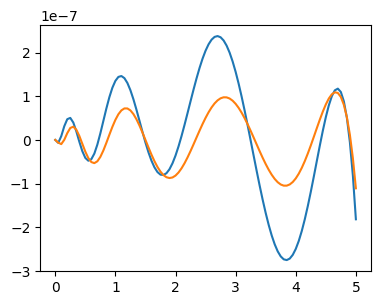

In [92]:
xt = 5.0
order = 8
x = torch.linspace(0.0, xt, 101).double()
# plt.plot(x, ierfcx(x))
# plt.plot(x, ierfcx_exact(x))
plt.plot(x, ierfcx_chebyshev(x, order=order, xt=xt) - ierfcx_exact(x))
plt.plot(x, ierfcx_chebyshev_np(x.numpy(), order=order, xt=xt) - ierfcx_exact(x))
plt.show()
# torch.testing.assert_close(ierfcx(x), torch.from_numpy(ierfcx_exact(x)).float())

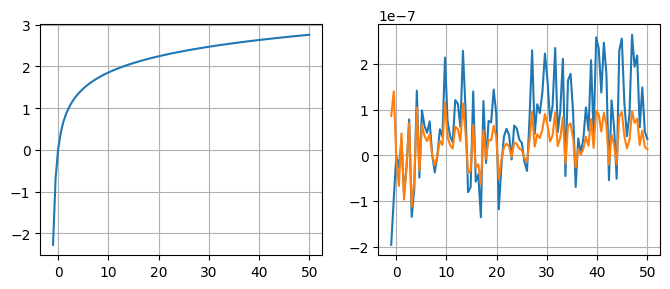

In [12]:
x = torch.linspace(-1, 50, 101)
# y = ierfcx(x, c=1, a=1, xt=3.25)  # float precision (rtol = 1.3e-6, atol = 1.0e-5)
# y = ierfcx(x.double(), c=8, a=8, xt=4.1)  # double precision (rtol = 1.0e-7, atol = 1.0e-7)
# y = ierfcx_fast(x.double())
y = ierfcx(x)
y_np_exact = ierfcx_exact(x)
fig, axes = plt.subplots(1, 2, figsize=(8, 3))
axes[0].plot(x, ierfcx(x))
# axes[0].plot(x, ierfcx_exact(x))
# axes[0].plot(x, ierfcx_approx(x))
axes[1].plot(x, y - y_np_exact)
axes[1].plot(x, (y - y_np_exact) / y_np_exact)
axes[0].grid(which='both')
axes[1].grid(which='both')
plt.show()
torch.testing.assert_close(y.float(), torch.from_numpy(y_np_exact).float())

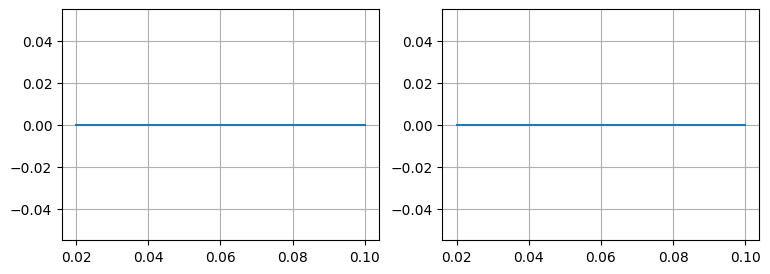

In [157]:
params = dict(tau=0.02, tau_rp=0.002, sigma_t=0.01, V_r=0.01, theta=0.02)
x = torch.linspace(0.02, 0.1, 101)
min_u = (params['V_r'] - x) / params['sigma_t']
max_u = (params['theta'] - x) / params['sigma_t']
# y = ricciardi(x, **params, c=8, a=8, xt=4.1)  # float precision (rtol = 1.3e-6, atol = 1.0e-5)
# y = ricciardi(x, **params, c=10, a=10, xt=4.5)  # double precision (rtol = 1.0e-7, atol = 1.0e-7)
y = ric2.ricciardi(x, **params)
# y_approx = ricciardi_approx(x, **params)
# y_np_exact = ricciardi_exact(x.double().numpy(), **params)
y_np_exact = ricciardi_np(x, **params, approx=False).astype(np.float32)
# y_np_approx = ricciardi_np(x, **params, approx=True)
# print(x)
# print(y)
# print(y_np_exact)
fig, axes = plt.subplots(1, 2, figsize=(9, 3))
# plt.plot(x, y)
# plt.plot(x, y_np_exact)
# plt.plot(x, y_approx)
# plt.plot(x, y_np_approx)
axes[0].plot(x, y - y_np_exact)
axes[1].plot(x, (y - y_np_exact) / y_np_exact)
# axes[0].plot(-min_u, params['tau_rp'] + params['tau'] * np.pi**0.5 * (ierfcx(-min_u) - ierfcx(-max_u)))
# axes[0].plot(-min_u, (ierfcx(-min_u) - ierfcx(-max_u)))
# axes[0].plot(-min_u, y - y_np_exact)
# axes[1].plot(-min_u, (y - y_np_exact) / y_np_exact)
# axes[1].plot(x, (y_np_approx - y_np_exact) / y_np_exact)
axes[0].grid(which='both')
axes[1].grid(which='both')
plt.show()
# print(y.dtype, y_np.dtype)

In [53]:
x = torch.linspace(-0.5, 0.5, 5, requires_grad=True).double()
y = ricciardi_fast(x, **params)
print(y)
# y.sum().backward()
# print(x.grad)
# print(x.grad.isnan().count_nonzero())
print(torch.autograd.functional.jacobian(ricciardi_fast, x).diag())
eps = 1.0e-6
print((ricciardi_fast(x[-1] + eps) - ricciardi_fast(x[-1] - eps)) / (2 * eps))
torch.autograd.gradcheck(ricciardi_fast, x)

tensor([ 0.0000e+00, 1.9102e-314,  9.4955e-01,  3.5083e+02,  4.1454e+02],
       dtype=torch.float64, grad_fn=<IndexPutBackward0>)
tensor([-0.0000e+00, 1.0308e-310,  3.3219e+02,  4.4473e+02,  1.4603e+02],
       dtype=torch.float64)
tensor(146.0340, dtype=torch.float64, grad_fn=<DivBackward0>)


True

In [150]:
x = torch.linspace(-10, 10, 10001)
# %lprun -f ierfcx ierfcx(x)
# %lprun -f ierfcx_fast -f dawson -f ierfcx_chebyshev_fast ierfcx_fast(x)
%lprun -f ierfcx_approx -f dawson_approx ierfcx_approx(x)
# %timeit ierfcx(x)
# %timeit ierfcx_fast(x)
# %timeit ierfcx_exact(x)

Timer unit: 1e-09 s

Total time: 0.000144 s
File: /Users/hoyinchau/local_documents/research/ricciardi/ricciardi_nb.py
Function: dawson_approx at line 70

Line #      Hits         Time  Per Hit   % Time  Line Contents
    70                                           def dawson_approx(x):
    71                                               """
    72                                               Very low precision rational approximation
    73                                               """
    74         1      10000.0  10000.0      6.9      absx = x.abs()
    75         1      12000.0  12000.0      8.3      t = x**2
    76         2      17000.0   8500.0     11.8      return torch.where(
    77         1      17000.0  17000.0     11.8          absx < 2.5,
    78         1      49000.0  49000.0     34.0          x * (1.145e0 - 8.426e-2 * t) / (1.085e0 + t),
    79         1      39000.0  39000.0     27.1          1 / (2 * x) * (1 + 0.5 / t),
    80                                    

In [154]:
x = torch.linspace(-0.01, 0.1, 10001)
# x = torch.linspace(-10.0, 50.0, 1001)
ric = Ricciardi(**params)
# %timeit ricciardi(x, **params)
%timeit ricciardi_fast(x, **params)
%timeit ricciardi_approx(x, **params)
%timeit ric(x)

1.31 ms ± 11 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
605 µs ± 11.2 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
451 µs ± 7.04 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


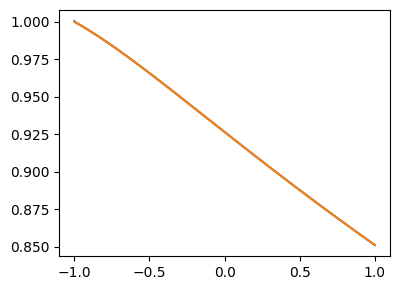

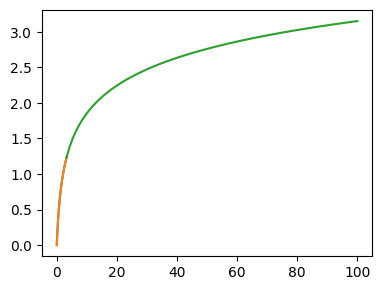

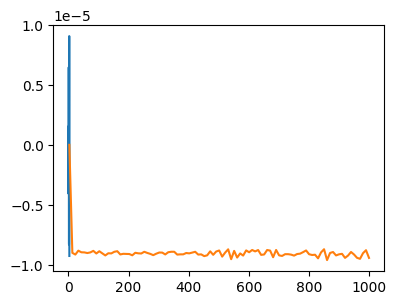

In [530]:
order = 5
asymptotic_order = 5
k = torch.arange(order + 1)
scale = 3.75
max_x = 3.25
min_t = -1.0
max_t = (max_x - scale) / (max_x + scale)
nodes = torch.cos((2 * k + 1) / (order + 1) * np.pi / 2).double()
a = 0.0

def F(t, min_t=-1.0, max_t=1.0):
    t = 0.5 * (min_t + max_t) + 0.5 * (max_t - min_t) * t
    x = inv_map(t, k=scale)
    # x = (t + 1) * (max_x - min_x) / 2 + min_x
    # return 0.0 * x + 1.0
    return 1 / torch.log(1.0 + x) * torch.from_numpy(erfcx_integral_exact(a, x))
    
coef = (F(nodes, min_t, max_t) * chebyshev(k[:, None], nodes)).sum(dim=-1) / (0.5 * (order + 1))
coef[0] = coef[0] / 2
# print(nodes)
# print(coef)

# x = torch.linspace(-2, 2, 101)
# a, b = x[:-1], x[1:]
# print(neg_erfcx_integral_approx(a, b, order=10))
# plt.plot(a, neg_erfcx_integral_approx(a, b, order=10))
# plt.plot(a, neg_erfcx_integral_exact(a, b), ls='--')
t = torch.linspace(-0.9999, 0.9999, 1001)
plt.plot(t, F(t, min_t, max_t))
plt.plot(t, (coef * chebyshev(k, t[:, None])).sum(dim=-1))
# torch.testing.assert_close(F(t), (coef * chebyshev(k, t[:, None])).sum(dim=-1))
plt.show()

x = torch.linspace(0.0, max_x - 1.0e-5, 101)
t = (x - scale) / (x + scale)
t = (t - 0.5 * (min_t + max_t)) / (0.5 * (max_t - min_t))
t[0] = -1.0  # numerical error
# t = 2 * (x - min_x) / (max_x - min_x) - 1
plt.plot(x, erfcx_integral_exact(a, x))
plt.plot(x, torch.log(1.0 + x) * (coef * chebyshev(k, t[:, None])).sum(dim=-1))
# plt.plot(x[:30], erfcx_integral_approx(x[:30]))
x = torch.linspace(max_x - 1.0e-5, 100, 101)
plt.plot(x, erfcx_integral_asymptotic(x, min_x=max_x, order=asymptotic_order))
plt.show()

x = torch.linspace(0.0, max_x - 1.0e-5, 101)
plt.plot(x, torch.from_numpy(erfcx_integral_exact(a, x)) - torch.log(1.0 + x) * (coef * chebyshev(k, t[:, None])).sum(dim=-1))
x = torch.linspace(max_x - 1.0e-5, 1000, 101)
plt.plot(x, torch.from_numpy(erfcx_integral_exact(a, x)) - erfcx_integral_asymptotic(x, min_x=max_x, order=asymptotic_order))
plt.show()
# print(erfcx_integral_exact(a, x))
# print(torch.log(1.0 + x) * (coef.float() * chebyshev(k, t[:, None])).sum(dim=-1))
x = torch.linspace(0.0, max_x - 1.0e-5, 101)
torch.testing.assert_close(torch.from_numpy(erfcx_integral_exact(a, x)).float(), torch.log(1.0 + x) * (coef.float() * chebyshev(k, t[:, None])).sum(dim=-1))
x = torch.linspace(max_x - 1.0e-5, 1000, 101)
torch.testing.assert_close(torch.from_numpy(erfcx_integral_exact(a, x)).float(), erfcx_integral_asymptotic(x, min_x=max_x, order=asymptotic_order))


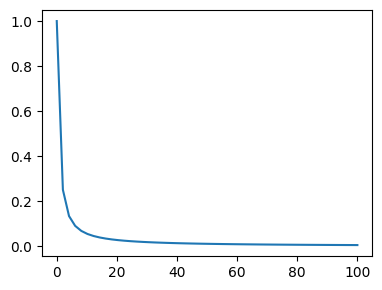

In [145]:
x = np.linspace(0, 100)
# plt.plot(x, (1 + 2 * x)*special.erfcx(x))
plt.plot(x, special.erfcx(x))
plt.show()

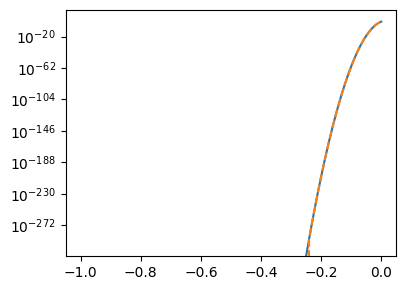

In [48]:
# ric_approx = Ricciardi()
# ric_exact = Ricciardi(approx=False)
params = dict(tau=0.02, tau_rp=0.002, sigma_t=0.01, V_r=0.01, theta=0.02)
mu = torch.linspace(-1, 0, 101)
# plt.plot(mu, ric_approx(mu))
# plt.plot(mu, ric_exact(mu), ls='--')
plt.plot(mu, ricciardi(mu, approx=True, **params))
plt.plot(mu, ricciardi(mu, approx=False, **params), ls='--')
plt.yscale('log')
plt.show()

In [53]:
mu = torch.linspace(-0.01, 0.1, 101)
sigma_t = 0.01
V_r = 0.01
theta = 0.02

min_u = (V_r - mu) / sigma_t
max_u = (theta - mu) / sigma_t

print(min_u[63], max_u[60])

tensor(-4.9300) tensor(-3.6000)


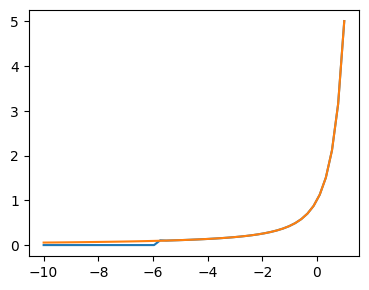

In [24]:
def integrand(x):
    return special.erfcx(-x)

x = np.linspace(-10, 1)
plt.plot(x, np.exp(x**2) * (1 + special.erf(x)))
plt.plot(x, integrand(x))
plt.show()

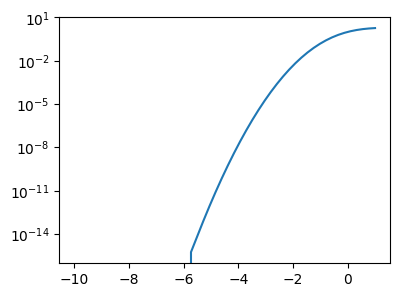

In [18]:
plt.plot(x, 1 + special.erf(x))
plt.yscale('log')
plt.show()

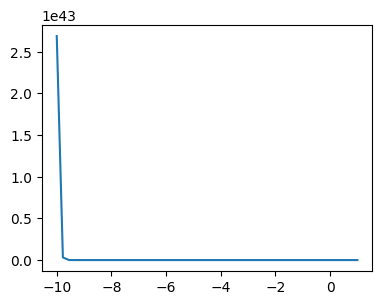

In [20]:
plt.plot(x, np.exp(x**2))
# plt.yscale('log')
plt.show()